# Approche “Modèle sur mesure avancé”

On va tester plusieurs modèles et choisir le meilleur pour ensuite l'entraîner et le déployer sur Azure Machine Learning

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import numpy as np
import time

from sklearn import metrics
from sklearn.model_selection import train_test_split

import keras_tuner as kt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dense, Dropout, LSTM, Flatten, Bidirectional, TextVectorization, Activation
from keras.models import Sequential, load_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras.metrics import AUC
import tensorflow as tf

import spacy
from nltk.stem import PorterStemmer

from gensim.models import word2vec

import src.helpers.data_helpers as dth

### Chargement des données

In [4]:
# Charger les données depuis le fichier csv
data = pd.read_csv('data/training.1600000.processed.noemoticon.csv', sep=',', encoding = "ISO-8859-1", header=None, names=['target', 'id', 'date', 'flag', 'user', 'text'])

# Ne garder que les colonnes nécessaires
data = data[["text", "target"]]

# On supprime les tweets en doublons
data.drop_duplicates(subset=['text'], inplace=True)

# Remplacer les valeurs par les vrais labels
data['target'] = data['target'].map(
    {
        0: "NEGATIF",
        4: "POSITIF"
    }
)

# Binarize target
data['target'] = data['target'].map(
    {
        "NEGATIF": 0,
        "POSITIF": 1,
    }
)

data.describe()

,target
count,1.581466e+06
mean,5.003465e-01
std,5.000000e-01
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


Comme on travaille en local pour déterminer le meilleur modèle, on va travailler sur un échantillion de 40 000 tweets afin de diminuer les temps de calcul.

Le meilleur modèle sera ré-entraîné sur Azure Machine Learning en utilisant la totalité du jeu de données.

In [5]:
# Echantillon du jeu de données
sample_positif = data[data["target"] == 1].sample(n = 20000)
sample_negatif = data[data["target"] == 0].sample(n = 20000)

sample = pd.concat([sample_negatif, sample_positif])

X = sample['text']
y = sample['target']

### Choix des métriques

Pour déterminer le meilleur modèle on fera une synthèse comparative avec les métriques suivantes :

- f1 score
- accuracy
- Recall
- ROC AUC
- Temps pour l'entraînement

In [6]:
import json

synthese = {}
train_times = {}
if os.path.exists('models/train_times.json'):
    with open('models/train_times.json', 'r') as f:
        train_times = json.load(f)

### Modèle simple avec lemmatisation / stemming et embedding Word2Vec / Glove

On va commencer par un modèle de Deep Learning simple composé d'une couche d'Embedding, une couche LSTM et une couche Dense.

On entraîne le modèle 4 fois en changeant la technique de prétraitement du texte, et la méthode de plongement de mots.

**Prétraitement du texte :**

- Lemmatisation
- Stemming

**Plongement de mots :**

- Word2Vec
- Glove



In [18]:
nlp = spacy.load('en_core_web_sm')

all_stopwords = nlp.Defaults.stop_words

# Ajout / Suppression de stop words
all_stopwords.add('re')
if 'not' in all_stopwords:
    all_stopwords.remove('not')

In [19]:
# Prétraitement du texte aveec lemmatization et suppression des stops words, des caractères spéciaux et passage en minuscule
X_lemma = [[token.lemma_.lower() for token in doc if token.is_alpha and token.lemma_.lower() not in all_stopwords] for doc in nlp.pipe(X)]

In [20]:
ps = PorterStemmer()

# Prétraitement du texte aveec stemming et suppression des stops words, des caractères spéciaux et passage en minuscule
X_stemm = [[ps.stem(token.text) for token in doc if token.is_alpha and token.text.lower() not in all_stopwords] for doc in nlp.pipe(X)]

In [21]:
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(X_lemma, y, test_size=0.2, stratify=y, random_state=42)

In [22]:
X_train_stemm, X_test_stemm, y_train_stemm, y_test_stemm = train_test_split(X_stemm, y, test_size=0.2, stratify=y, random_state=42)

In [23]:
# Dictionnaire pour le plongement de mots avec Glove
emmbed_dict = {}
with open('data/glove.twitter.27B.200d.txt', 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        emmbed_dict[word] = vector

print(f'Il y a {len(emmbed_dict)} mots vectorisés')

Il y a 1193514 mots vectorisés


In [24]:
# Retourne l'embedding avec Word2Vec
def createEmbeddingLayerWord2Vec(tokenizer, X_train):
    w2v_model = word2vec.Word2Vec(vector_size=300, min_count=5)

    w2v_model.build_vocab(X_train)

    w2v_model.train(X_train, total_examples=w2v_model.corpus_count, epochs=32)

    vocab_size = len(tokenizer.word_index) + 1

    embedding_matrix = np.zeros((vocab_size, 300))

    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv.index_to_key:
            embedding_matrix[i] = w2v_model.wv.get_vector(word, norm=True)

    return Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

# Retourne l'embedding avec Glove
def createEmbeddingLayerGlove(tokenizer, emmbed_dict):

    vocab_size = len(tokenizer.word_index) + 1

    embedding_matrix = np.zeros((vocab_size, 200))

    for word, i in tokenizer.word_index.items():
        embedding_vector = emmbed_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=200, trainable=False)

In [25]:
# Tokenizer avec lemmatization
tokenizer_lemma = Tokenizer()
tokenizer_lemma.fit_on_texts(X_train_lemma)

# Tokenizer avec stemming
tokenizer_stemm = Tokenizer()
tokenizer_stemm.fit_on_texts(X_train_stemm)

def tokenize_data(data,tokenizer,maxlen=None):
    X = tokenizer.texts_to_sequences(data)
    return pad_sequences(X,maxlen=maxlen)

In [26]:
# Modèle de deep learning simple
def trainModel(model_name, embedding_layer, X_train, y_train, X_test, y_test, embedding_dim, tokenizer):

    x_train = tokenize_data(X_train,tokenizer,maxlen=embedding_dim)
    x_test = tokenize_data(X_test,tokenizer,maxlen=embedding_dim)

    model_path = os.path.join('models', model_name)

    if os.path.exists(model_path):
        model = load_model(model_path)
        training_time = train_times[model_name]

    else:
        start_train = time.time()
        # Create LSTM Model
        model = Sequential(name=model_name)
        model.add(embedding_layer)
        model.add(LSTM(256))

        # Classification layer
        model.add(Dense(1, activation='sigmoid'))

        # Compile
        model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ["AUC","accuracy"])

        print(model.summary())

        # Train
        model.fit(
            x_train,
            y_train,
            validation_split=0.2,
            epochs = 4,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=2),
            ],
            workers=4,
            use_multiprocessing=True,)

        # Save the model
        model.save(model_path)

        end_train = time.time()
        training_time = end_train - start_train
        train_times[model_name] = training_time

    start_pred = time.time()

    y_test_pred_proba = model.predict(
        x_test,
        batch_size=128,
        workers=4,
        use_multiprocessing=True,
    )

    y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

    end_pred= time.time()
    predict_time = end_pred - start_pred

    synthese[model_name] = dth.getMetrics(y_test, y_test_pred, y_test_pred_proba, training_time, predict_time)

    print(f"Resultats modèle : {model_name}")

    dth.plot_classifier_results(model, x_test, y_test, y_test_pred, y_test_pred_proba)

Entraînement des 4 modèles

Model: "stemm_word2vec_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          6054900   
                                                                 
 lstm (LSTM)                 (None, 256)               570368    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 6,625,525
Trainable params: 570,625
Non-trainable params: 6,054,900
_________________________________________________________________
None
Epoch 1/4
800/800 [==============================] - 654s 815ms/step - loss: 0.5643 - auc: 0.7801 - accuracy: 0.7099 - val_loss: 0.5488 - val_auc: 0.7973 - val_accuracy: 0.7116
Epoch 2/4
800/800 [==============================] - 697s 872ms/step - loss: 0.5306 - auc: 0.8092 - accuracy: 0.7

INFO:tensorflow:Assets written to: models\stemm_word2vec_lstm\assets


INFO:tensorflow:Assets written to: models\stemm_word2vec_lstm\assets


Resultats modèle : stemm_word2vec_lstm


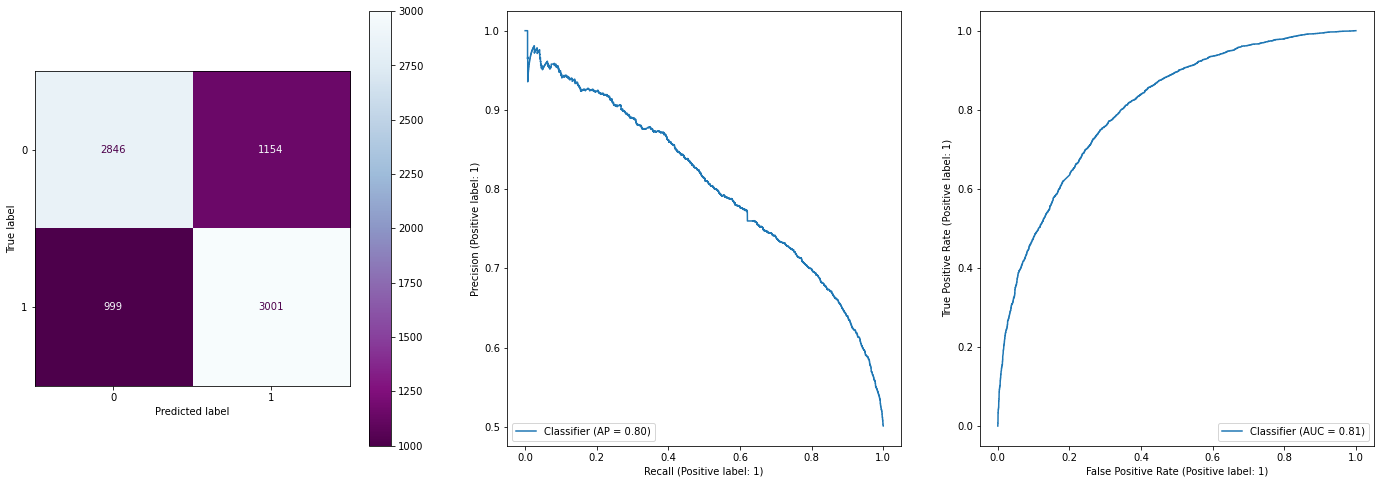

Model: "lemma_word2vec_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          6750000   
                                                                 
 lstm_1 (LSTM)               (None, 256)               570368    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 7,320,625
Trainable params: 570,625
Non-trainable params: 6,750,000
_________________________________________________________________
None
Epoch 1/4
800/800 [==============================] - 721s 901ms/step - loss: 0.5670 - auc: 0.7782 - accuracy: 0.7076 - val_loss: 0.5459 - val_auc: 0.7968 - val_accuracy: 0.7222
Epoch 2/4
800/800 [==============================] - 731s 915ms/step - loss: 0.5348 - auc: 0.8062 - accuracy: 0.7

INFO:tensorflow:Assets written to: models\lemma_word2vec_lstm\assets


INFO:tensorflow:Assets written to: models\lemma_word2vec_lstm\assets


Resultats modèle : lemma_word2vec_lstm


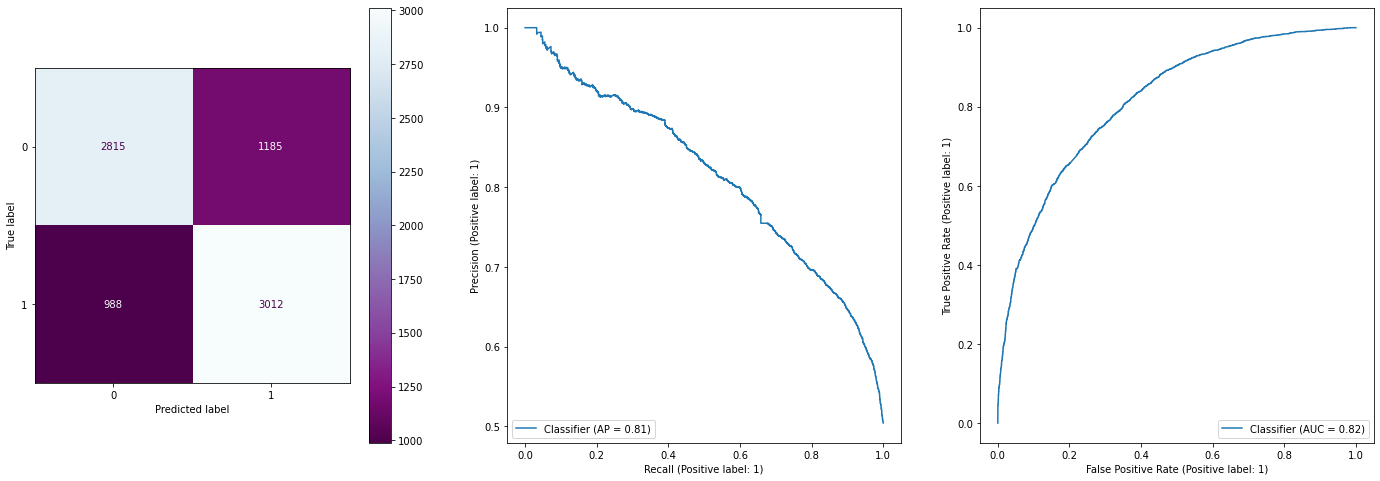

Model: "stemm_glove_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 200)          4036600   
                                                                 
 lstm_2 (LSTM)               (None, 256)               467968    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 4,504,825
Trainable params: 468,225
Non-trainable params: 4,036,600
_________________________________________________________________
None
Epoch 1/4
800/800 [==============================] - 331s 411ms/step - loss: 0.5434 - auc: 0.7992 - accuracy: 0.7230 - val_loss: 0.5235 - val_auc: 0.8204 - val_accuracy: 0.7372
Epoch 2/4
800/800 [==============================] - 341s 426ms/step - loss: 0.4982 - auc: 0.8366 - accuracy: 0.7554

INFO:tensorflow:Assets written to: models\stemm_glove_lstm\assets


INFO:tensorflow:Assets written to: models\stemm_glove_lstm\assets


Resultats modèle : stemm_glove_lstm


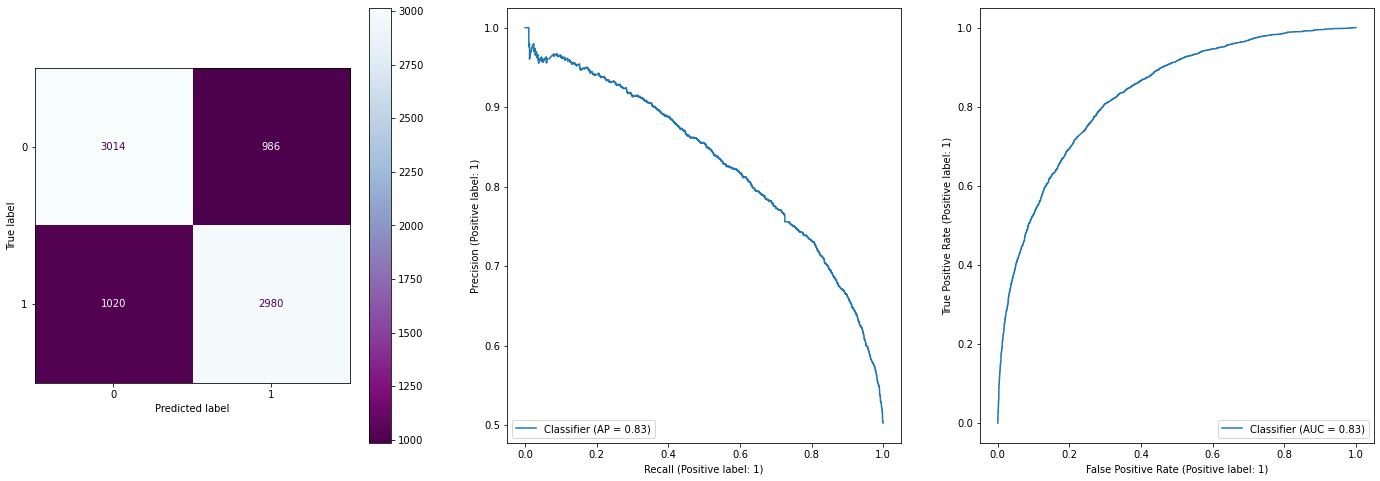

Model: "lemma_glove_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 200)          4500000   
                                                                 
 lstm_3 (LSTM)               (None, 256)               467968    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 4,968,225
Trainable params: 468,225
Non-trainable params: 4,500,000
_________________________________________________________________
None
Epoch 1/4
800/800 [==============================] - 334s 417ms/step - loss: 0.5291 - auc: 0.8114 - accuracy: 0.7327 - val_loss: 0.5079 - val_auc: 0.8319 - val_accuracy: 0.7470
Epoch 2/4
800/800 [==============================] - 331s 414ms/step - loss: 0.4895 - auc: 0.8427 - accuracy: 0.7592

INFO:tensorflow:Assets written to: models\lemma_glove_lstm\assets


INFO:tensorflow:Assets written to: models\lemma_glove_lstm\assets


Resultats modèle : lemma_glove_lstm


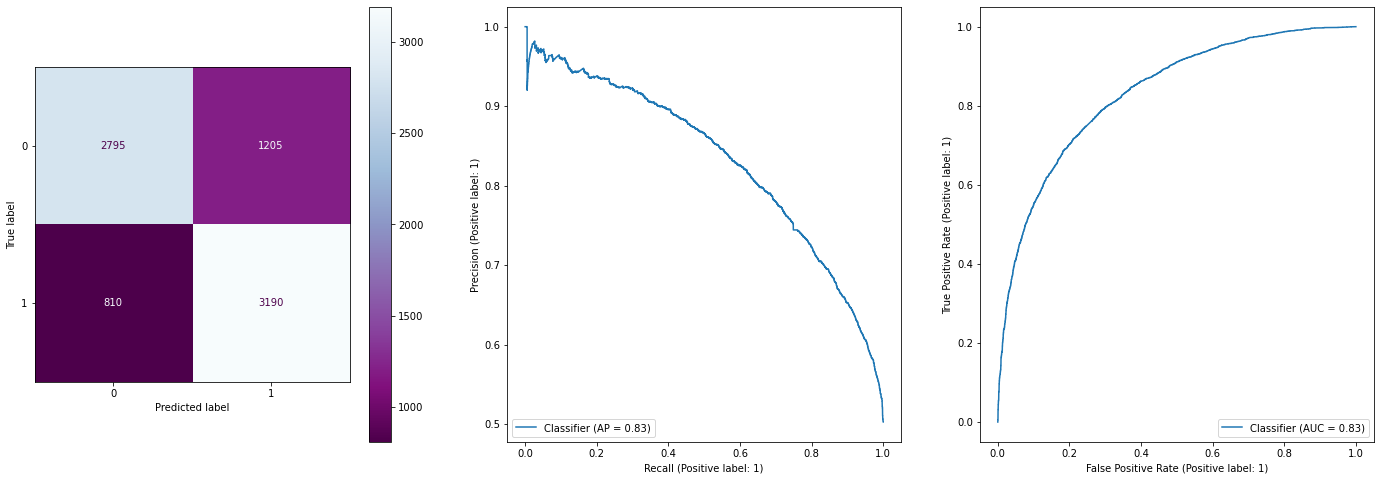

In [27]:
trainModel('stemm_word2vec_lstm', createEmbeddingLayerWord2Vec(tokenizer_stemm, X_train_stemm), X_train_stemm, y_train_stemm, X_test_stemm, y_test_stemm, 300, tokenizer_stemm)

trainModel('lemma_word2vec_lstm', createEmbeddingLayerWord2Vec(tokenizer_lemma, X_train_lemma), X_train_lemma, y_train_lemma, X_test_lemma, y_test_lemma, 300, tokenizer_lemma)

trainModel('stemm_glove_lstm', createEmbeddingLayerGlove(tokenizer_stemm, emmbed_dict), X_train_stemm, y_train_stemm, X_test_stemm, y_test_stemm, 200, tokenizer_stemm)

trainModel('lemma_glove_lstm', createEmbeddingLayerGlove(tokenizer_lemma, emmbed_dict), X_train_lemma, y_train_lemma, X_test_lemma, y_test_lemma, 200, tokenizer_lemma)

Le meillleur prétraitement ici serait la **Lemmatisation** suivi d'un plongement de mot avec **Glove**

On utilisera cette combinaison dans un modèle plus poussé

### Modèle Feed-Forward Neural Network

Avec un simple vecteur comptant les mots en entrée, sans prétraitement de texte

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

In [29]:
model_name = "ffnn_on_count"
vocabulary_size = 10000

model_path = os.path.join('models', model_name)

if os.path.exists(model_path):
    model = load_model(model_path)
    training_time = train_times[model_name]

else:
    start_train = time.time()
    # Define vectorizer
    vectorize_layer = TextVectorization(
            output_mode="count",
            max_tokens=vocabulary_size,
            pad_to_max_tokens=True,
        )
    vectorize_layer.adapt(
            X,
            batch_size=128,
        )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)
    model.add(Dense(100, input_shape=(vocabulary_size,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
            loss="binary_crossentropy",
            optimizer="adam",
            metrics=[
                "accuracy",
                AUC(curve="ROC", name="ROC_AUC"),
                AUC(curve="PR", name="AP"),
            ],
        )

    # fit NN model
    model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=128,
            validation_split=0.2,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=2),
            ],
            workers=4,
            use_multiprocessing=True,
        )

    # Save the model
    model.save(model_path)
    
    end_train = time.time()
    training_time = end_train - start_train
    train_times[model_name] = training_time

Epoch 1/10
200/200 [==============================] - 4s 14ms/step - loss: 0.5567 - accuracy: 0.7286 - ROC_AUC: 0.7973 - AP: 0.7850 - val_loss: 0.5063 - val_accuracy: 0.7633 - val_ROC_AUC: 0.8350 - val_AP: 0.8197
Epoch 2/10
200/200 [==============================] - 2s 11ms/step - loss: 0.4224 - accuracy: 0.8159 - ROC_AUC: 0.8900 - AP: 0.8860 - val_loss: 0.4974 - val_accuracy: 0.7697 - val_ROC_AUC: 0.8422 - val_AP: 0.8346
Epoch 3/10
200/200 [==============================] - 2s 11ms/step - loss: 0.3373 - accuracy: 0.8591 - ROC_AUC: 0.9315 - AP: 0.9304 - val_loss: 0.5262 - val_accuracy: 0.7603 - val_ROC_AUC: 0.8364 - val_AP: 0.8273
Epoch 4/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2550 - accuracy: 0.8974 - ROC_AUC: 0.9618 - AP: 0.9622 - val_loss: 0.5891 - val_accuracy: 0.7561 - val_ROC_AUC: 0.8321 - val_AP: 0.8229
INFO:tensorflow:Assets written to: models\ffnn_on_count\assets


INFO:tensorflow:Assets written to: models\ffnn_on_count\assets


In [30]:
start_pred = time.time()

y_test_pred_proba = model.predict(
    X_test,
    batch_size=128,
    workers=4,
    use_multiprocessing=True,
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

end_pred = time.time()
predict_time = end_pred - start_pred

synthese[model_name] = dth.getMetrics(y_test, y_test_pred, y_test_pred_proba, training_time, predict_time)

Resultats modèle : ffnn_on_count


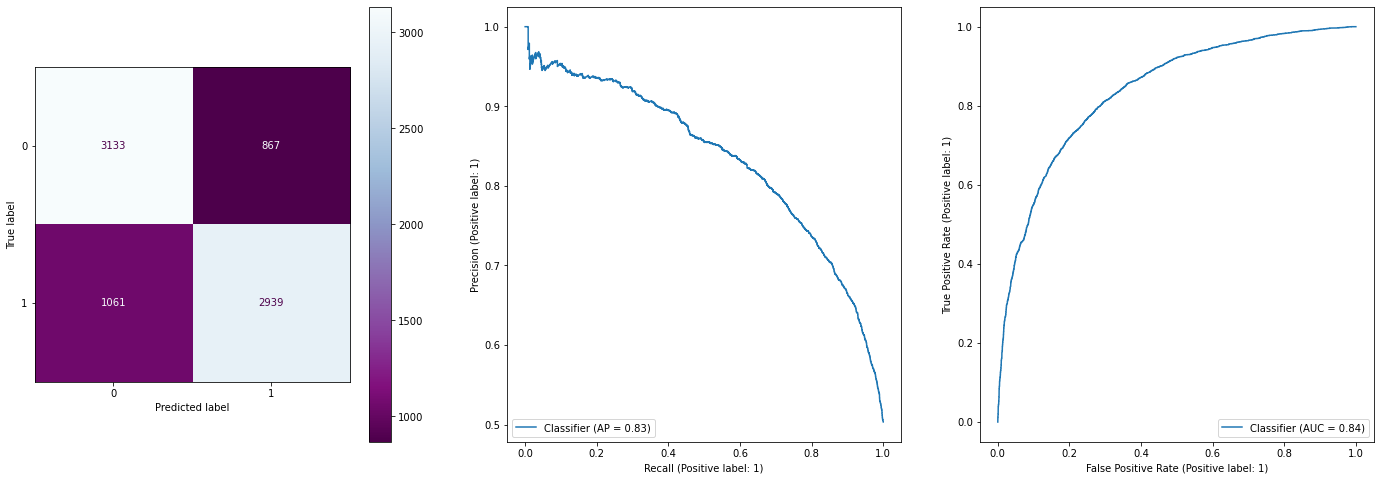

In [31]:
print(f"Resultats modèle : {model_name}")

dth.plot_classifier_results(model, X_test, y_test, y_test_pred, y_test_pred_proba)

## Modèle bidirectional LSTM (embedding automatique)

Chaque mot est converti en nombre, et l'embedding est automatique sur la couche Embedding

In [32]:
model_name = "bidirectional_lstm"
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

model_path = os.path.join('models', model_name)

if os.path.exists(model_path):
    model = load_model(model_path)
    training_time = train_times[model_name]

else:
    start_train = time.time()
    # Define vectorizer
    vectorize_layer = TextVectorization(
            output_mode="int",
            max_tokens=max_features,
            output_sequence_length=sequence_length,
        )
    vectorize_layer.adapt(
            X,
            batch_size=128,
        )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)

    # Embedding layer
    model.add(
            Embedding(
                max_features,
                embedding_dim,
                input_length=sequence_length,
            )
        )

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=rnn_units, dropout=0.2)))

    # Dense layers
    model.add(Dense(100, input_shape=(max_features,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation="relu"))

    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
            loss="binary_crossentropy",
            optimizer="adam",
            metrics=[
                "accuracy",
                AUC(curve="ROC", name="ROC_AUC"),
                AUC(curve="PR", name="AP"),
            ],
        )

    # fit NN model
    model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=128,
            validation_split=0.2,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=2),
            ],
            workers=4,
            use_multiprocessing=True,
        )

    # Save the model
    model.save(model_path)

    end_train = time.time()
    training_time = end_train - start_train
    train_times[model_name] = training_time   

Epoch 1/10
200/200 [==============================] - 29s 131ms/step - loss: 0.5645 - accuracy: 0.7024 - ROC_AUC: 0.7784 - AP: 0.7754 - val_loss: 0.4932 - val_accuracy: 0.7644 - val_ROC_AUC: 0.8447 - val_AP: 0.8426
Epoch 2/10
200/200 [==============================] - 24s 120ms/step - loss: 0.4322 - accuracy: 0.8075 - ROC_AUC: 0.8822 - AP: 0.8809 - val_loss: 0.4852 - val_accuracy: 0.7700 - val_ROC_AUC: 0.8480 - val_AP: 0.8457
Epoch 3/10
200/200 [==============================] - 25s 124ms/step - loss: 0.3756 - accuracy: 0.8413 - ROC_AUC: 0.9121 - AP: 0.9121 - val_loss: 0.5060 - val_accuracy: 0.7636 - val_ROC_AUC: 0.8422 - val_AP: 0.8360
Epoch 4/10
200/200 [==============================] - 25s 122ms/step - loss: 0.3248 - accuracy: 0.8656 - ROC_AUC: 0.9347 - AP: 0.9364 - val_loss: 0.5491 - val_accuracy: 0.7578 - val_ROC_AUC: 0.8341 - val_AP: 0.8253


INFO:tensorflow:Assets written to: models\bidirectional_lstm\assets


INFO:tensorflow:Assets written to: models\bidirectional_lstm\assets


In [33]:
start_pred = time.time()

y_test_pred_proba = model.predict(
    X_test,
    batch_size=128,
    workers=4,
    use_multiprocessing=True,
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

end_pred= time.time()
predict_time = end_pred - start_pred

synthese[model_name] = dth.getMetrics(y_test, y_test_pred, y_test_pred_proba, training_time, predict_time)

Resultats modèle : bidirectional_lstm


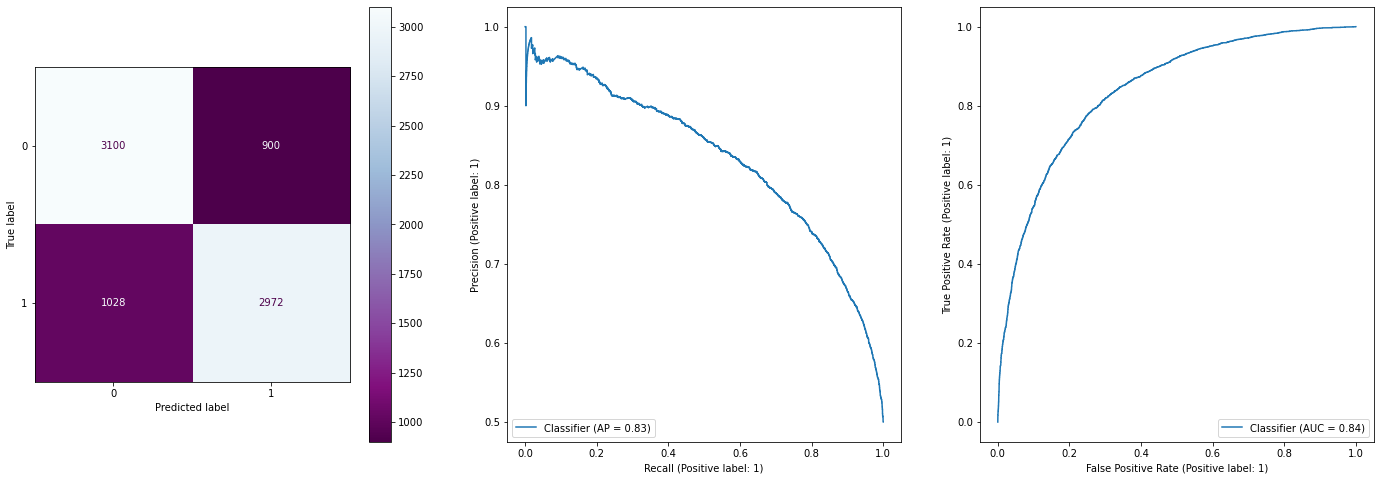

In [34]:
print(f"Resultats modèle : {model_name}")

dth.plot_classifier_results(model, X_test, y_test, y_test_pred, y_test_pred_proba)

## Modèle bidirectionnal LSTM (Embedding personnalisé)

- C'est fois ci sur la couche d'Embedding on utilise le meilleur plongement de mots déterminé précédemment: **Glove**.
- Un prétaitement de texte est appliqué sur les tweets avec la **Lemmatisation**

In [35]:
embedding_layer = createEmbeddingLayerGlove(tokenizer_lemma, emmbed_dict)

x_train_lemma = tokenize_data(X_train_lemma, tokenizer_lemma, maxlen=200)
x_test_lemma = tokenize_data(X_test_lemma, tokenizer_lemma, maxlen=200)

model_name = "lemma_glove_bidirectional_lstm"
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

model_path = os.path.join('models', model_name)

if os.path.exists(model_path):
    model = load_model(model_path)
    training_time = train_times[model_name]

else:
    start_train = time.time()
    # define NN model
    model = Sequential(name=model_name)
    model.add(embedding_layer)

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=rnn_units, dropout=0.2)))

    # Dense layers
    model.add(Dense(100, input_shape=(max_features,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation="relu"))

    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ["AUC","accuracy"])

    # fit NN model
    model.fit(
            x_train_lemma,
            y_train_lemma,
            epochs=10,
            batch_size=128,
            validation_split=0.2,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=2),
            ],
            workers=4,
            use_multiprocessing=True,
        )
    
    # Save the model
    model.save(model_path)

    end_train = time.time()
    training_time = end_train - start_train
    train_times[model_name] = training_time

Epoch 1/10
200/200 [==============================] - 206s 1s/step - loss: 0.5631 - auc: 0.7792 - accuracy: 0.7037 - val_loss: 0.5123 - val_auc: 0.8270 - val_accuracy: 0.7466
Epoch 2/10
200/200 [==============================] - 206s 1s/step - loss: 0.5152 - auc: 0.8233 - accuracy: 0.7465 - val_loss: 0.5050 - val_auc: 0.8324 - val_accuracy: 0.7520
Epoch 3/10
200/200 [==============================] - 218s 1s/step - loss: 0.4991 - auc: 0.8355 - accuracy: 0.7541 - val_loss: 0.4987 - val_auc: 0.8360 - val_accuracy: 0.7522
Epoch 4/10
200/200 [==============================] - 222s 1s/step - loss: 0.4837 - auc: 0.8465 - accuracy: 0.7648 - val_loss: 0.4973 - val_auc: 0.8375 - val_accuracy: 0.7536
Epoch 5/10
200/200 [==============================] - 218s 1s/step - loss: 0.4716 - auc: 0.8556 - accuracy: 0.7720 - val_loss: 0.4977 - val_auc: 0.8370 - val_accuracy: 0.7523
Epoch 6/10
200/200 [==============================] - 217s 1s/step - loss: 0.4553 - auc: 0.8667 - accuracy: 0.7834 - val_loss

INFO:tensorflow:Assets written to: models\lemma_glove_bidirectional_lstm\assets


INFO:tensorflow:Assets written to: models\lemma_glove_bidirectional_lstm\assets


In [36]:
start_pred = time.time()

y_test_pred_proba = model.predict(
        x_test_lemma,
        batch_size=128,
        workers=4,
        use_multiprocessing=True,
    )

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

end_pred= time.time()
predict_time = end_pred - start_pred

synthese[model_name] = dth.getMetrics(y_test, y_test_pred, y_test_pred_proba, training_time, predict_time)

Resultats modèle : lemma_glove_bidirectional_lstm


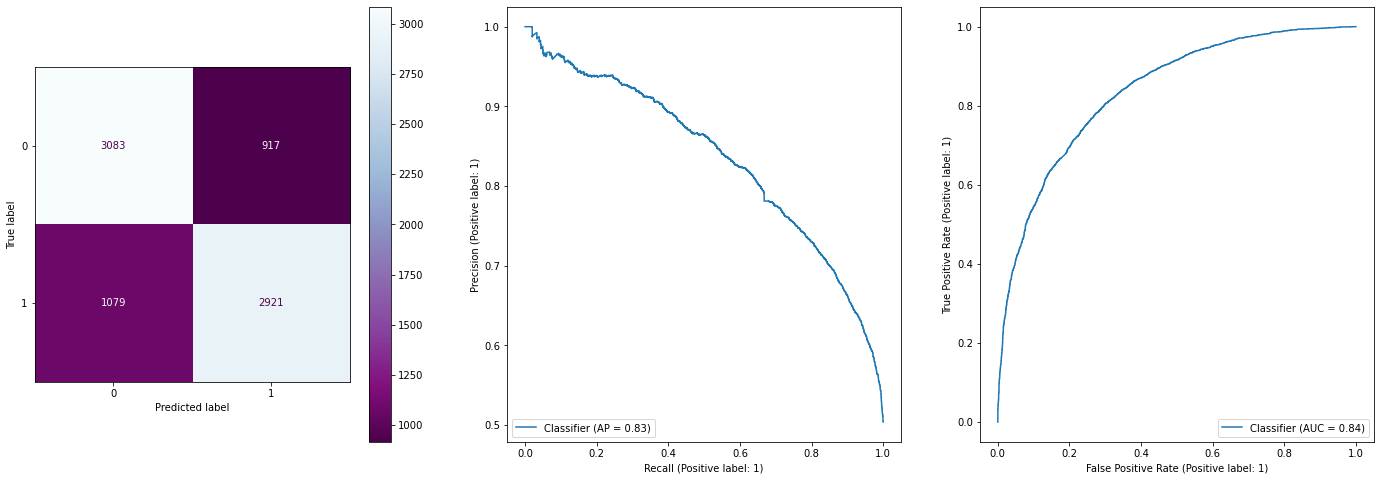

In [37]:
print(f"Resultats modèle : {model_name}")

dth.plot_classifier_results(model, x_test_lemma, y_test_lemma, y_test_pred, y_test_pred_proba)

## Modèle BERT

On passe à 10 000 tweets pour entraîner le modèle Bert, sinon l'entraînement est trop long en local.

In [38]:
# Echantillon du jeu de données
sample_positif = data[data["target"] == 1].sample(n = 5000)
sample_negatif = data[data["target"] == 0].sample(n = 5000)

sample = pd.concat([sample_negatif, sample_positif])

X = sample['text']
y = sample['target']

In [39]:
X_cleaned= pd.Series(" ".join([token.text.lower() for token in doc if token.is_alpha and token.text.lower() not in all_stopwords]) for doc in nlp.pipe(X))

In [40]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

In [41]:
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [42]:
max_len = 0

for tweet in X_cleaned:
    max_len = max(max_len, len(tweet))

print('Max tweet length: ', max_len)

Max tweet length:  123


In [43]:
def mask_inputs_for_bert(tweets, max_len):
    input_ids = []
    attention_masks = []

    for tweet in tweets:
        encoded_dict = tokenizer.encode_plus(
            tweet,
            add_special_tokens = True,
            max_length = max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask = True
        )
    
        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    
    return input_ids, attention_masks

In [44]:
train_inp, train_mask = mask_inputs_for_bert(X_train, max_len)
test_inp, test_mask = mask_inputs_for_bert(X_test, max_len)
train_label = tf.convert_to_tensor(y_train)
test_label = tf.convert_to_tensor(y_test)

In [45]:
print("Train_input shape", train_inp.shape)
print("Train_mask shape", train_mask.shape)
print("Test_input shape", test_inp.shape)
print("Test_mask shape", test_mask.shape)
print("Train_label shape", train_label.shape)
print("Test_label shape", test_label.shape)

Train_input shape (8000, 123)
Train_mask shape (8000, 123)
Test_input shape (2000, 123)
Test_mask shape (2000, 123)
Train_label shape (8000,)
Test_label shape (2000,)


In [46]:
model_name = "bert"

model_path = os.path.join('models', model_name)

if os.path.exists(model_path):
    bert_model = load_model(model_path)
    training_time = train_times[model_name]

else:
    start_train = time.time()

    bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

    bert_model.compile(
            loss=loss,
            optimizer=optimizer,
            metrics=[metric])

    bert_model.fit(
            [train_inp, train_mask],
            train_label,
            epochs=10,
            batch_size=256,
            validation_data=([test_inp, test_mask], test_label),
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=2),
            ],
            workers=4,
            use_multiprocessing=True,
        )
    
    # Save the model
    bert_model.save(model_path)

    end_train = time.time()
    training_time = end_train - start_train
    train_times[model_name] = training_time

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
32/32 [==============================] - 10843s 341s/step - loss: 0.6663 - accuracy: 0.5947 - val_loss: 0.5941 - val_accuracy: 0.6995
Epoch 2/10
32/32 [==============================] - 10876s 340s/step - loss: 0.5408 - accuracy: 0.7319 - val_loss: 0.5356 - val_accuracy: 0.7275
Epoch 3/10
32/32 [==============================] - 10895s 341s/step - loss: 0.4667 - accuracy: 0.7797 - val_loss: 0.5461 - val_accuracy: 0.7405
Epoch 4/10
32/32 [==============================] - 10360s 326s/step - loss: 0.4095 - accuracy: 0.8238 - val_loss: 0.5671 - val_accuracy: 0.7385


INFO:tensorflow:Assets written to: models\bert\assets


INFO:tensorflow:Assets written to: models\bert\assets


In [47]:
start_pred = time.time()

y_test_pred_proba = bert_model([test_inp, test_mask])

prediction_logits = y_test_pred_proba[0]

prediction_probs = tf.nn.softmax(prediction_logits,axis=1).numpy()

prediction_probs_bis = []

for element in prediction_probs:
    prediction_probs_bis.append(element[1])

y_test_pred = [round(pred_proba) for pred_proba in prediction_probs_bis]

end_pred = time.time()
predict_time = end_pred - start_pred

synthese[model_name] = dth.getMetrics(y_test, y_test_pred, prediction_probs_bis, training_time, predict_time)


Resultats modèle : bert


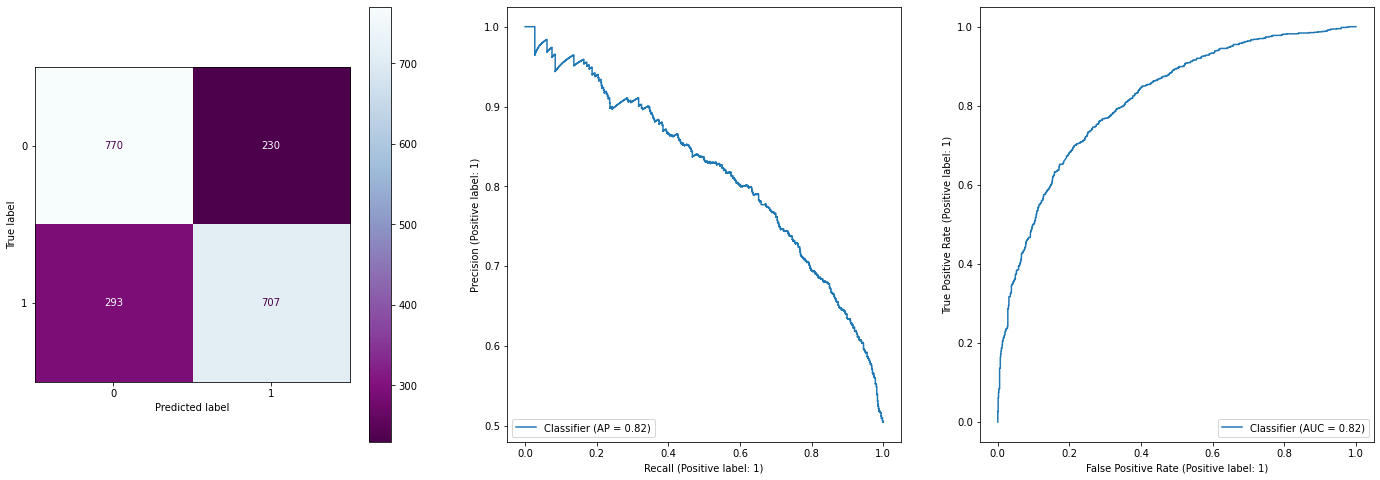

In [48]:
print(f"Resultats modèle : {model_name}")

dth.plot_classifier_results(bert_model, [test_inp, test_mask], y_test, y_test_pred, prediction_probs_bis)

## Synthèse comparative

In [49]:
with open('models/train_times.json', 'w') as f:
    json.dump(train_times, f)

In [50]:
pd.DataFrame.from_dict(synthese, orient='index')

,f1 score,accuracy,recall,AUC,Training time,Predict time
stemm_word2vec_lstm,0.735990,0.730875,0.75025,0.808369,2748.045996,41.721033
lemma_word2vec_lstm,0.734903,0.728375,0.75300,0.815676,2919.961647,41.136918
stemm_glove_lstm,0.748180,0.749250,0.74500,0.832600,1352.690617,25.179829
lemma_glove_lstm,0.759976,0.748125,0.79750,0.832917,1322.217251,22.548970
ffnn_on_count,0.753011,0.759000,0.73475,0.837795,12.630544,0.468640
bidirectional_lstm,0.755081,0.759000,0.74300,0.840007,110.829946,2.969728
lemma_glove_bidirectional_lstm,0.745343,0.750500,0.73025,0.836737,1295.711264,28.104391
bert,0.729995,0.738500,0.70700,0.816139,43009.508111,449.201372


## Optimisation des hyperparamètres - Modèle bidirectionnal LSTM

In [28]:
def build_model(hp):

    # Define vectorizer
    vectorize_layer = TextVectorization(
            output_mode="int",
            max_tokens=10000,
            output_sequence_length=30,
        )
    vectorize_layer.adapt(
            X,
            batch_size=128,
        )
    
    # define NN model
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)

    # Embedding layer
    model.add(
            Embedding(
                10000,
                100,
                input_length=30,
            )
        )

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=hp.Choice('units_lstm', [50, 100, 150, 200]),
                                 dropout=hp.Choice('dropout_lstm', [0.2, 0.4, 0.6]))))

    # Dense layers
    model.add(Dense(hp.Choice('units_dense', [50, 100, 150, 200]), input_shape=(10000,), activation="relu"))
    model.add(Dropout(hp.Choice('dropout', [0.2, 0.4, 0.6])))
    model.add(Dense(10, activation="relu"))

    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
            loss="binary_crossentropy",
            optimizer="adam",
            metrics=[
                "accuracy",
                AUC(curve="ROC", name="ROC_AUC"),
                AUC(curve="PR", name="AP"),
            ],
        )

    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = EarlyStopping(monitor='val_loss', patience=2)

tuner.search(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 59s]
val_accuracy: 0.7685937285423279

Best val_accuracy So Far: 0.7737500071525574
Total elapsed time: 00h 30m 34s
INFO:tensorflow:Oracle triggered exit


In [42]:
# Les meilleurs paramètres sont :

print("Les meilleurs paramètres :")
print(f"    Param 'units' couche LSTM : {best_hps.get('units_lstm')}")
print(f"    Param 'dropout' couche LSTM : {best_hps.get('dropout_lstm')}")
print(f"    Param 'units' couche Dense : {best_hps.get('units_dense')}")
print(f"    Param 'dropout' couche Dense : {best_hps.get('dropout')}")

Les meilleurs paramètres :
    Param 'units' couche LSTM : 50
    Param 'dropout' couche LSTM : 0.4
    Param 'units' couche Dense : 150
    Param 'dropout' couche Dense : 0.2


In [30]:
# Build the model with the optimal hyperparameters and train it on the data for 10 epochs
model = tuner.hypermodel.build(best_hps)

history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
800/800 [==============================] - 23s 25ms/step - loss: 0.5506 - accuracy: 0.7169 - ROC_AUC: 0.7921 - AP: 0.7910 - val_loss: 0.4834 - val_accuracy: 0.7745 - val_ROC_AUC: 0.8516 - val_AP: 0.8490
Epoch 2/10
800/800 [==============================] - 20s 25ms/step - loss: 0.4330 - accuracy: 0.8011 - ROC_AUC: 0.8811 - AP: 0.8830 - val_loss: 0.4776 - val_accuracy: 0.7773 - val_ROC_AUC: 0.8540 - val_AP: 0.8524
Epoch 3/10
800/800 [==============================] - 21s 27ms/step - loss: 0.3722 - accuracy: 0.8335 - ROC_AUC: 0.9141 - AP: 0.9160 - val_loss: 0.5099 - val_accuracy: 0.7675 - val_ROC_AUC: 0.8428 - val_AP: 0.8392
Epoch 4/10
800/800 [==============================] - 21s 27ms/step - loss: 0.3201 - accuracy: 0.8591 - ROC_AUC: 0.9370 - AP: 0.9397 - val_loss: 0.5405 - val_accuracy: 0.7613 - val_ROC_AUC: 0.8346 - val_AP: 0.8306
Epoch 5/10
800/800 [==============================] - 21s 27ms/step - loss: 0.2773 - accuracy: 0.8793 - ROC_AUC: 0.9530 - AP: 0.9549 - val_loss:

In [31]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/2
800/800 [==============================] - 22s 24ms/step - loss: 0.5496 - accuracy: 0.7163 - ROC_AUC: 0.7924 - AP: 0.7933 - val_loss: 0.4855 - val_accuracy: 0.7677 - val_ROC_AUC: 0.8508 - val_AP: 0.8493
Epoch 2/2
800/800 [==============================] - 20s 26ms/step - loss: 0.4273 - accuracy: 0.8030 - ROC_AUC: 0.8846 - AP: 0.8861 - val_loss: 0.4936 - val_accuracy: 0.7767 - val_ROC_AUC: 0.8511 - val_AP: 0.8488


In [33]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy, test ROC_AUC, test AP]:", eval_result)

250/250 [==============================] - 1s 5ms/step - loss: 0.4916 - accuracy: 0.7674 - ROC_AUC: 0.8519 - AP: 0.8506
[test loss, test accuracy, test ROC_AUC, test AP]: [0.49156346917152405, 0.7673749923706055, 0.8518708348274231, 0.8506168127059937]


In [34]:
y_test_pred_proba = hypermodel.predict(
    X_test,
    batch_size=128,
    workers=4,
    use_multiprocessing=True,
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

Resultats modèle avec optimisation


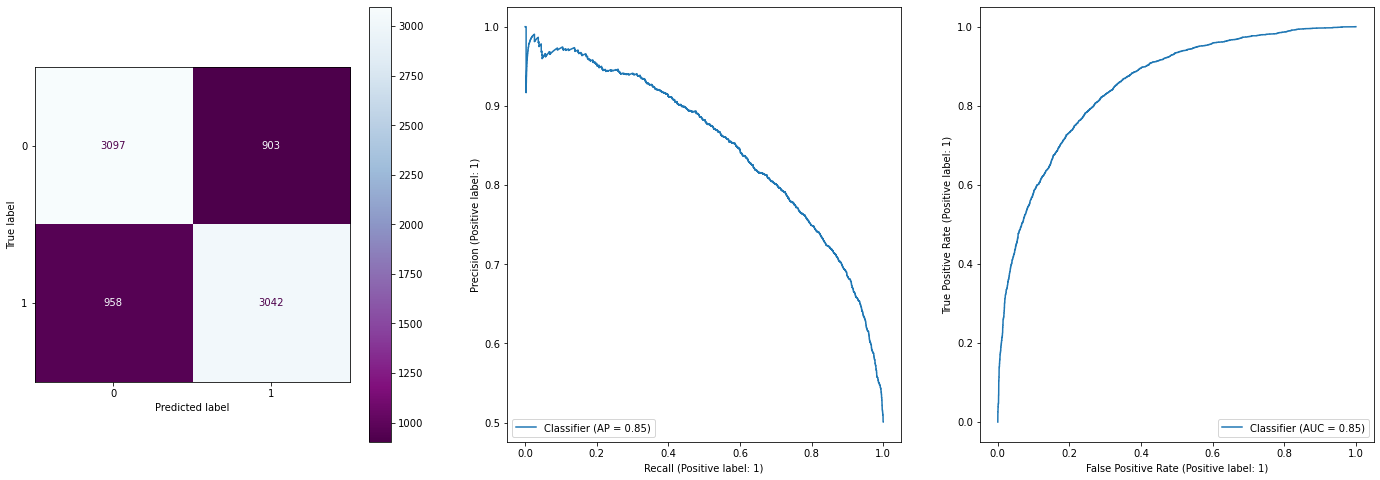

In [35]:
print(f"Resultats modèle avec optimisation")

dth.plot_classifier_results(hypermodel, X_test, y_test, y_test_pred, y_test_pred_proba)

## Conclusion

On voit que le prétraitement et le plongement de mots n'augmentent pas nécessairement la performance du modèle, par contre les temps d'entraînement et de prédiction sont grandement impactés.

Ceci peut s'expliquer par la taille des tweets qui font au maximum 150 caractères. Après le prétraitement il ne reste plus beaucoup de mots et on perd donc en précision.

Le meilleur modèle ici serait le **bidirecitonal_lstm** avec une conversion des mots en nombre (TextVectorization) et un embedding automatique.

On obtient :

- **Recall**: 0.74
- **AUC**: 0.84

De plus les temps d'entraînement et de prédiction sont très bons.

On va maintenant entraîner ce modèle sur Azure Machine Learning en utilisant cette fois la totalité du jeu de données. Cela augmentera la précision de notre modèle.
